# Facial Detection and Recognition app using Deep learning
In this project we will leverage the Siamese Neural Network structure  to build a facial detection and recognition app  
This Network is an implementation of the Siamese Network from this paper:  
<a href = "https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf">Siamese Neural Networks for One-shot Image Recognition</a>

## 1. Setting Up the environment 

In [2]:
# import general dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import random
import tensorflow as tf
import shutil
import uuid

In [3]:
# import tensorflow dependencies
from keras.models import Model
from keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

### Set GPU Growth
limiting how much of the GPU RAM tensorflow is going to take

In [4]:
#%pip install tensorflow-gpu

In [5]:
# # Avoid OOM errors by setting GPU memory consumption growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)

### Create Folder structures

In [6]:
# setup paths: for the triplets (anchor, positive, negative)
POS_PATH = os.path.join('data', 'positive')  # to store the positive images
NEG_PATH = os.path.join('data', 'negative')  # to store the negative images
ANCH_PATH = os.path.join('data', 'anchor')  # to store the anchor images 

In [7]:
# # create the directories using the defined paths
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANCH_PATH)

## 2. Data Collection
Collecting positives and anchors
### Load *Labelled Faces in the Wild* dataset
#### Move LFW Images to the following repository data/negative

In [8]:
# source_dir = 'labelled faces in the wild/lfw-deepfunneled/lfw-deepfunneled'
# for directory in os.listdir(source_dir):
#     person_folder = os.path.join(source_dir, directory)
    
#     # Check if it's a directory
#     if os.path.isdir(person_folder):
#         # Iterate through all files in the person folder
#         for file in os.listdir(person_folder):
#             EX_PATH = os.path.join(person_folder, file)  # Corrected to include the subdirectory
#             NEW_PATH = os.path.join(NEG_PATH, file)
            
#             # Use shutil.copy to handle cross-device issues
#             shutil.copy(EX_PATH, NEW_PATH)

#### Collect Positive and Anchor Pictures
Using OpenCV to access the webcam and collect positive images  
Desired Sized **250x250**

In [9]:
# # we need around 400 pics
# # establish a connection to the webcam
# cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
# if not cap.isOpened():
#     print("Cannot open camera")
#     exit()
# while cap.isOpened:
#     # capture the frame at that point in time
#     ret, frame = cap.read()  # returns value and frame

#     # image back to screen
#     cv2.imshow('Image Collection', frame)

#     # Collect Positives
#     if cv2.waitKey(1) & 0XFF == ord('p'):
#         # define unique image name
#         img_name = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         # put the image in the positive folder
#         cv2.imwrite(img_name, frame)

#     # Collect Anchors
#     if cv2.waitKey(1) & 0XFF == ord('a'):
#         # define unique image name
#         img_name = os.path.join(ANCH_PATH, '{}.jpg'.format(uuid.uuid1()))
#         # put the image in the anchor folder
#         cv2.imwrite(img_name, frame)

#     # breaking gracefully
#     if cv2.waitKey(1) & 0XFF == ord('q'):
#         break
# # release the webcam
# cap.release()
# # close the image window frame
# cv2.destroyAllWindows()    

copy the pictures of the anchor - thatwere not taken by video cam - to the **anchor folder**, same for positive pictures and renaming them using the `uuid` library

In [10]:
# # copy the anchor pics
# source_dir = 'ranwa anchor/'
# target_dir = 'data/anchor/'
# for picture in os.listdir(source_dir):
#     # old path of the picture
#     EX_PATH = os.path.join(source_dir, picture)
#     # define unique name for the image
#     pic_name =  os.path.join('{}.jpg'.format(uuid.uuid1()))
#     # new path of the picture
#     NEW_PATH = os.path.join(target_dir, pic_name)
    
#     # Use shutil.copy to handle cross-device issues
#     shutil.copy(EX_PATH, NEW_PATH)

In [11]:
# # copy the positive pics
# source_dir = 'ranwa positive/'
# target_dir = 'data/positive/'
# for picture in os.listdir(source_dir):
#     # old path of the picture
#     EX_PATH = os.path.join(source_dir, picture)
#     # define unique name for the image
#     pic_name =  os.path.join('{}.jpg'.format(uuid.uuid1()))
#     # new path of the picture
#     NEW_PATH = os.path.join(target_dir, pic_name)
    
#     # Use shutil.copy to handle cross-device issues
#     shutil.copy(EX_PATH, NEW_PATH)

## 3. Data Prepping 
- First of all we need to crop the images to only include the faces  
- Then we need to resize them to be `250x250`  
  
This may result in stretching some of the pictures but that's fine

### Step 1: Cropping Faces
Using `OpenCV`'s deep neural networks

In [12]:
# load the model files
pb = "opencv_face_detector_uint8.pb"
pbtxt = "opencv_face_detector.pbtxt"

In [13]:
# load the face detector model from OpenCV
net = cv2.dnn.readNetFromTensorflow(pb, pbtxt)

In [14]:
# create a method to use the face detector model and return a cropped version of the face only
def crop_faces(net, frame):
    """
    A method that uses OpenCV face detector model to detect a face in an image, 
    crop the rest of the picture leaving just the face and returing the cropped image.

    Parameters:
    net (OpenCV deep neural network): the face detector model that will be used
    frame (image): the image in which we want to detect and crop the face

    Returns:
    face (image): the new cropped image containing only the face 

    """

    # prepare the image for the dnn model
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104., 177., 123.], False, False)
    net.setInput(blob)
    # perform feed forward to detect the face 
    detections = net.forward()
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        # Only consider detections if confidence is greater than a fixed minimum confidence:
        if confidence > 0.7:
            # Get the coordinates of the current detection:
            box = detections[0, 0, i, 3:7] * np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]])
            # convert the coordinates to integers
            (startX, startY, endX, endY) = box.astype("int")
            # crop the image
            face = frame[startY:endY, startX:endX]
            
            return face  # Return the cropped and resized face
    
    #return np.zeros((100,100,3))
    return None  # Return None if no face is detected

In [15]:
# # copy the anchor pics
# source_dir = 'pre-cropping/anchor/'
# target_dir = 'data/anchor/'
# for picture in os.listdir(source_dir):
#     # old path of the picture
#     EX_PATH = os.path.join(source_dir, picture)
#     # load image 
#     old_img = cv2.imread(EX_PATH)

#     if old_img is None:
#         print(f"Skipping picture: {EX_PATH} (unable to load image)")
#         continue
    
#     # crop the picture to contain the face only 
#     cropped_pic = crop_faces(net, old_img)
#     if cropped_pic is not None and cropped_pic.size > 0:
#         # define unique name for the image
#         pic_name =  os.path.join('{}.jpg'.format(uuid.uuid1()))
#         # new path of the picture
#         NEW_PATH = os.path.join(target_dir, pic_name)
        
#         # put the cropped image in the new path
#         cv2.imwrite(NEW_PATH, cropped_pic)
#     else:
#         print(f"Skipping picture: {EX_PATH}")

In [16]:
# # copy the positive pics
# source_dir = 'pre-cropping/positive/'
# target_dir = 'data/positive/'
# for picture in os.listdir(source_dir):
#     # old path of the picture
#     EX_PATH = os.path.join(source_dir, picture)
#     # load image 
#     old_img = cv2.imread(EX_PATH)

#     if old_img is None:
#         print(f"Skipping picture: {EX_PATH} (unable to load image)")
#         continue
    
#     # crop the picture to contain the face only 
#     cropped_pic = crop_faces(net, old_img)
#     if cropped_pic is not None and cropped_pic.size > 0:
#         # define unique name for the image
#         pic_name =  os.path.join('{}.jpg'.format(uuid.uuid1()))
#         # new path of the picture
#         NEW_PATH = os.path.join(target_dir, pic_name)
        
#         # put the cropped image in the new path
#         cv2.imwrite(NEW_PATH, cropped_pic)
#     else:
#         print(f"Skipping picture: {EX_PATH}")

## Step 2: Scaling and Resizing
### 2.1 Get Image directories
Using the tensorflow Dataset class 

In [17]:
anchor = tf.data.Dataset.list_files(ANCH_PATH + '\*.jpg').take(200)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(200)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(200)

In [18]:
positive.as_numpy_iterator().next()

b'data\\positive\\30a6200e-6201-11ef-98ef-f56d5633b199.jpg'

### 2.2 Cropping images, scaling and resizing images

In [19]:
anchor.as_numpy_iterator().next()

b'data\\anchor\\0f0d88e5-6201-11ef-9614-f56d5633b199.jpg'

In [20]:
def preprocess(file_path):
    """
    Preprocesses the image file by cropping faces, resizing, and scaling.

    Parameters:
    file_path (tf.Tensor): Path to the image file.

    Returns:
    tf.Tensor: Preprocessed image.
    """
    # Load the byte image from path
    byte_img = tf.io.read_file(file_path)
    # Decode the image
    img = tf.image.decode_jpeg(byte_img)
    
    # Convert image to uint8
    img = tf.image.convert_image_dtype(img, dtype=tf.uint8)

    # Resize and scale the image
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0

    return img

(100, 100, 3)


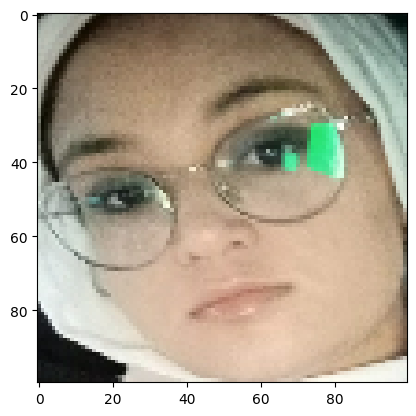

In [21]:
img1 = preprocess(r"D:\Uni stuff\2nd year\IoT Training\Face ID model\data\anchor\097401c7-6201-11ef-a9a5-f56d5633b199.jpg")
print(img1.shape)
plt.imshow(img1)

### Step 3: Create Labelled Dataset
(anchor, positive) => 1,1,1,1,1  
(anchor, negative) => 0,0,0,0,0 

In [22]:
positive_paths_and_labels= tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negative_paths_and_labels = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positive_paths_and_labels.concatenate(negative_paths_and_labels)

In [23]:
# print one sample of our data
example = data.as_numpy_iterator().next()
example

(b'data\\anchor\\0398d221-6201-11ef-888b-f56d5633b199.jpg',
 b'data\\positive\\33f1e393-6201-11ef-9a35-f56d5633b199.jpg',
 1.0)

After we've created those tuples we need to get the images, preprocess them and return them back concatenated into the same tuple format

In [24]:
# method to apply preprocessing on the images in the tuple and return concatenated tuple again with the label
def preprocess_pair(input_img, validation_img, label):
    return preprocess(input_img), preprocess(validation_img), label

In [25]:
# def preprocess_pair(input_img, validation_img, label):
#     """
#     Preprocesses a pair of images and the associated label.

#     Parameters:
#     input_img (tf.Tensor): Path to the input image.
#     validation_img (tf.Tensor): Path to the validation image.
#     label (tf.Tensor): The label for the images.

#     Returns:
#     tuple: Preprocessed input image, validation image, and label.
#     """
#     input_img = tf.py_function(preprocess, [input_img], tf.float32)
#     validation_img = tf.py_function(preprocess, [validation_img], tf.float32)
    
#     input_img.set_shape([100, 100, 3])  # Set shape
#     validation_img.set_shape([100, 100, 3])  # Set shape

#     return input_img, validation_img, label

In [26]:
# try out the method on the example
preprocess_pair(*example)

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.12988922, 0.1455755 , 0.14165393],
         [0.09608216, 0.11176843, 0.10784686],
         [0.08834314, 0.1040294 , 0.10010784],
         ...,
         [0.09012744, 0.09404901, 0.10973528],
         [0.0676937 , 0.07161526, 0.08730154],
         [0.0685151 , 0.08420137, 0.09596608]],
 
        [[0.08179922, 0.09748549, 0.09356392],
         [0.10571432, 0.12140059, 0.11747903],
         [0.09969018, 0.11039606, 0.1064745 ],
         ...,
         [0.0717176 , 0.07563917, 0.09132545],
         [0.06843702, 0.08412329, 0.095888  ],
         [0.04003923, 0.0557255 , 0.06749021]],
 
        [[0.09332745, 0.10117059, 0.09724902],
         [0.08271862, 0.09056176, 0.08664019],
         [0.21197551, 0.21981865, 0.21589708],
         ...,
         [0.08585285, 0.08977442, 0.09761756],
         [0.03610096, 0.05178723, 0.06355194],
         [0.07747059, 0.09423529, 0.106     ]],
 
        ...,
 
        [[0.256768  , 0.24431731

Now we need to apply the `preprocess_pair()` function on all pairs in the `data` variable

In [27]:
tf.compat.v1.enable_eager_execution()

In [28]:
# Building data loader pipeline
#tf.config.run_functions_eagerly(True)
# apply the preprocessing function to all the pairs in data
data = data.map(preprocess_pair)
# subsequent epochs (or iterations) can use the cached data rather than reloading and reprocessing it.
data = data.cache()
# shuffling it so that they're mixed up so we can do the train/test split
data = data.shuffle(buffer_size=1024)

In [29]:
# training partition: train size = 70%
train_data = data.take(round(len(data)*0.7))
# batch the data
train_data = train_data.batch(16)
# starts preprocessing the next set of images
train_data = train_data.prefetch(8)

In [30]:
# testing partition: test size = 30%
test_data = data.skip(round(len(data)*0.7))  # skip the training sample
test_data = data.take(round(len(data)*0.3))  # take the remaining 30%
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Building a Siamese Neural Network for face recognition
1. Build an Embedding Layer
2. Creating an L1 Distance Layer (for comapison anchor with positive/ nnegative twin)
3. Compile to build the Siamese Network  

### Building Embedding layer 


In [31]:
def make_embedding():
    # create input layer
    input_img = Input(shape = (100,100,3), name = "Input_Image")

    # first block
    # add convolution layer: ReLU, 64 filters, stride = 1
    convolution1 = Conv2D(64, (10, 10), activation='relu')(input_img)
    # add maxpooling layer: 64 filters, padding: same
    maxpooling1 = MaxPooling2D(64, (2,2), padding='same')(convolution1)

    # second block
    convolution2 = Conv2D(128, (7, 7), activation='relu')(maxpooling1)
    # add maxpooling layer: 64 filters, padding: same
    maxpooling2 = MaxPooling2D(64, (2,2), padding='same')(convolution2)

    # third block
    convolution3 = Conv2D(128, (4, 4), activation='relu')(maxpooling2)
    # add maxpooling layer: 64 filters, padding: same
    maxpooling3 = MaxPooling2D(64, (2,2), padding='same')(convolution3)

    # final embedding block
    convolution4 = Conv2D(256, (4,4), activation='relu')(maxpooling3)
    # we pass it to a dense fully connected layer 
    flattened1 = Flatten()(convolution4)
    dense1 = Dense(4096, activation='sigmoid')(flattened1)

    return Model(inputs = input_img, outputs = dense1, name = 'Embedding')

In [32]:
embedding = make_embedding()
embedding.summary()

Model: "Embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

### Building the L1 distance layer
Tells us how similar the two branches (of the siamese NN) are similar to each other 

In [49]:
# creating a new class for a custom L1 distance layer
class L1Distance(Layer):
    # inheriting our L1 layer from the tf.keras.Layer class
    def __init__(self, **kwargs):
        super().__init__()
    
    @tf.function
    # combine the anchor with a twin to get the similarity: which is the abs of the difference between their embedding
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

### Build Siamese Model

In [50]:
def siamese_model():

    # input the anchor image to the network
    input_image = Input(name="input_image", shape = (100,100,3))
    # input the validation image to the network
    validation_image = Input(name = "val_image", shape = (100,100,3))

    # combine siamese distance components
    siamese_layer = L1Distance()  # create a L1 distance layer
    siamese_layer._name = 'distance'
    # calculate the l1 distances
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # classification layer 
    class_layer = Dense(1, activation='sigmoid')(distances)

    return Model(inputs = [input_image, validation_image], outputs = class_layer, name = "SiameseNN")

In [51]:
siameseNN = siamese_model()
siameseNN.summary()

Model: "SiameseNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ val_image           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding           │ (None, 4096)      │ 38,960,448 │ input_image[0][0… │
│ (Functional)        │                   │            │ val_image[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_distance_2       │ (None, 4096)      │          0 │ Embedding[2][0],  │
│ (L1Distance)        │                   │            │ Embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_distance_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Siamese Model
### Loss and Optimizer  
**Loss Function**  
Since we're performing binary classification (yes/ no) or **(0/1)** we will be using the `Binary Crossentropy` as our loss function during training  
  
**Optimizer**  
We will use the `Adam` optimizer with a learning rate of `0.0001`

In [52]:
# define binary crossentropy function
binary_crossentropy_loss = tf.losses.BinaryCrossentropy()
# define an optimizer
adam_optimizer = tf.keras.optimizers.Adam(1e-4)  # lr = 0.0001

### Create Checkpoints

In [53]:
# define a checkpoint directory where we'll save our checkpoints
checkpoints_dir = './training_checkpoints'
# set a naming standard for our checkpoints so that they all start with "cptk"
checkpoints_prefix = os.path.join(checkpoints_dir, 'ckpt')
# create the checkpoints object and passing our optimizer and our model
checkpoint = tf.train.Checkpoint(opt = adam_optimizer, siamese_model = siameseNN)

### Build Train step function
which is the function that trains on a single batch of the data

In [54]:
# wrap the function as a tf.function when compiling as graph
@tf.function
def train_step(batch):
    """
    a wrapped function (as a tf.function to be compiled in the graph) 
    to train on one batch of data at a time

    Parameters:
    batch (tuple): a tuple of size 3 composed of (a batch of anchors, a batch of positives/ negatives, a batch of label)
    representing a single batch of data
    """
    # recording what's happening in the NN to be able to calculate the differentiation of the gradient
    with tf.GradientTape() as tape:
        # get the anchor and its twin (positive/negative)
        x = batch[:2]
        # get the label
        y = batch[2]

        # applying feed forward
        y_hat = siameseNN(x, training=True)
        # calculate loss
        loss = binary_crossentropy_loss(y, y_hat)
    print(loss)
    
    # Calculate Gradients
    gradient = tape.gradient(loss, siameseNN.trainable_variables)
    # update the weights and apply the siamese model
    adam_optimizer.apply_gradients(zip(gradient, siameseNN.trainable_variables))

    return loss

### Build training loop
inside of which the training batch function will be called

In [55]:
def train(data, EPOCHS):
    # loop through epochs
    for epoch in range(1, EPOCHS+1):
        print(f'\n Epochs {epoch}/{EPOCHS}')
        # define progress bar
        progbar = tf.keras.utils.Progbar(EPOCHS/2)

        # loop through each batch
        for idx, batch in enumerate(data):
            # call the train step function
            train_step(batch)
            progbar.update(idx+1)

        # save checkpoints every 10 epochs
        if epoch %10 == 0:
            checkpoint.save(file_prefix = checkpoints_prefix)

### Train the model

In [ ]:
# define number of epochs 
EPOCHS = 50

train(train_data, EPOCHS)


 Epochs 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
17/25 ━━━━━━━━━━━━━━━━━━━━ 6s 870ms/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
18/25 ━━━━━━━━━━━━━━━━━━━━ 6s 914ms/step
 Epochs 2/50
18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 842ms/step
 Epochs 3/50
18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 847ms/step
 Epochs 4/50
18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 841ms/step
 Epochs 5/50
18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 851ms/step
 Epochs 6/50
18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 850ms/step
 Epochs 7/50
18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 853ms/step
 Epochs 8/50
18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 838ms/step
 Epochs 9/50
18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 852ms/step
 Epochs 10/50
18/25 ━━━━━━━━━━━━━━━━━━━━ 6s 865ms/step
 Epochs 11/50
18/25 ━━━━━━━━━━━━━━━━━━━━ 5s 844ms/step
 Epochs 12/50
18/25 ━━━━━━━━━━━━━━━━━━━━ 6s 885ms/step
 Epochs 13/50
18/25 ━━━━━━━━━━━━━━━━━━━━ 6s 869ms/step
 Epochs 14/50
18/25 ━━━━━━━━━━━━━━━━━━━━ 6s 870ms/step
 Ep

## Evaluate The Model
Calcuating the accuracy measures: `Precision` and `Recall`

### Make Predictions

In [75]:
# import metric calculations 
from keras.metrics import Precision, Recall

# Get a batch of the test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
# make predictions
y_hat = siameseNN.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


array([[9.9998415e-01],
       [7.7884186e-05],
       [3.9597935e-06],
       [9.9939567e-01],
       [3.9691928e-05],
       [5.4837124e-06],
       [3.2706166e-04],
       [7.6584931e-04],
       [9.9964666e-01],
       [6.6216761e-11],
       [3.1307932e-06],
       [4.7433669e-08],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9976516e-01]], dtype=float32)

In [76]:
# post processing the results by converting the sigmoid probs to classes according to a threshold
[1 if pred > 0.5 else 0 for pred in y_hat]

[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]

In [77]:
y_true

array([1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1.],
      dtype=float32)

In [78]:
import numpy as np
from keras.metrics import Precision, Recall

# Initialize lists to store the true labels and predictions
y_true = []
y_pred = []

# Iterate over the entire test dataset
for test_input, test_val, labels in test_data:
    # Make predictions for the current batch
    y_hat = siameseNN.predict([test_input, test_val])
    
    # Convert the sigmoid probabilities to binary classes
    y_hat = [1 if pred > 0.5 else 0 for pred in y_hat]
    
    # Append the predictions and true labels to the lists
    y_true.extend(labels)
    y_pred.extend(y_hat)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate precision and recall
precision = Precision()
recall = Recall()

# Update the state of the metrics
precision.update_state(y_true, y_pred)
recall.update_state(y_true, y_pred)

# Get the final result
precision_result = precision.result().numpy()
recall_result = recall.result().numpy()

print(f'Precision: {precision_result:.4f}')
print(f'Recall: {recall_result:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
Precision: 1.0000
Recall: 1.0000


## Save the model
### Save the model weights

In [80]:
# save weights
siameseNN.save('siamesemodel.h5')

In [40]:
# reload the model
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects = {'L1Distance': L1Distance, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [41]:
test_data.as_numpy_iterator().next()

(array([[[[0.99990475, 0.851434  , 0.8175245 ],
          [0.99663293, 0.79898626, 0.79934204],
          [0.9844177 , 0.6111236 , 0.6877314 ],
          ...,
          [0.8594606 , 0.25340602, 0.4764044 ],
          [0.9063729 , 0.37570876, 0.5639526 ],
          [0.87374985, 0.38983646, 0.5528992 ]],
 
         [[0.9985318 , 0.8360557 , 0.81512845],
          [0.95207703, 0.6814775 , 0.69630665],
          [0.96626663, 0.5617745 , 0.6486039 ],
          ...,
          [0.83875144, 0.19609022, 0.43277383],
          [0.8286516 , 0.26019776, 0.4617412 ],
          [0.8474117 , 0.31755987, 0.5001313 ]],
 
         [[0.9536824 , 0.71445495, 0.71798533],
          [0.918049  , 0.6008255 , 0.63586175],
          [0.98826474, 0.54265195, 0.64930886],
          ...,
          [0.7936522 , 0.11181365, 0.36454424],
          [0.8564203 , 0.23732494, 0.4609888 ],
          [0.89223117, 0.31056526, 0.5150967 ]],
 
         ...,
 
         [[0.5875245 , 0.19836962, 0.28317347],
          [0.57005

In [42]:
# make predictions with loaded model
# import metric calculations 
from keras.metrics import Precision, Recall

# Get a batch of the test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
# make predictions
y_hat = model.predict([test_input, test_val])

print(f'predicted labels: {[1 if pred > 0.5 else 0 for pred in y_hat]}\nTrue labels: {y_true}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
predicted labels: [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]
True labels: [1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.]


In [43]:
# Initialize lists to store the true labels and predictions
y_true = []
y_pred = []

# Iterate over the entire test dataset
for test_input, test_val, labels in test_data:
    # Make predictions for the current batch
    y_hat = model.predict([test_input, test_val])
    
    # Convert the sigmoid probabilities to binary classes
    y_hat = [1 if pred > 0.5 else 0 for pred in y_hat]
    
    # Append the predictions and true labels to the lists
    y_true.extend(labels)
    y_pred.extend(y_hat)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate precision and recall
precision = Precision()
recall = Recall()

# Update the state of the metrics
precision.update_state(y_true, y_pred)
recall.update_state(y_true, y_pred)

# Get the final result
precision_result = precision.result().numpy()
recall_result = recall.result().numpy()

print(f'Precision: {precision_result:.4f}')
print(f'Recall: {recall_result:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
Precision: 0.4825
Recall: 0.9821


In [44]:
# view model summary
model.summary()

Model: "SiameseNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ val_image           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Embedding           │ (None, 4096)      │ 38,960,448 │ input_image[0][0… │
│ (Functional)        │                   │            │ val_image[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_distance_1       │ (None, 4096)      │          0 │ Embedding[0][0],  │
│ (L1Distance)        │                   │            │ Embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_distance_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## Live Feed Verification
We need to open the live feed of the web cam and then:
1. Detect if there's any face in the fraame and take a cropped frame of `100x100x3` around the face  
2. Take that frame and apply preprocessing on it
3. Get the anchor images and apply preprocessing on them as well 
4. make the prediction using the captured frame and each of the anchor image and appending that to the `results` list 
5. get the labels in the array from the probs and then compare the list against the verification thereshold to return positive or negative

In [45]:
anchor_paths = []

# Convert the TensorFlow dataset into a NumPy iterator and loop through it
for data in anchor.as_numpy_iterator():
    anchor_paths.append(data)

# Now anchor_paths contains all the paths in the anchor dataset
print(anchor_paths)

[b'data\\anchor\\094d20db-6201-11ef-b2cd-f56d5633b199.jpg', b'data\\anchor\\12fba6ce-6201-11ef-829c-f56d5633b199.jpg', b'data\\anchor\\034ac219-6201-11ef-9e9d-f56d5633b199.jpg', b'data\\anchor\\11bdf5d2-6201-11ef-acf5-f56d5633b199.jpg', b'data\\anchor\\053fa78d-6201-11ef-b49a-f56d5633b199.jpg', b'data\\anchor\\0ec0795d-6201-11ef-ab5d-f56d5633b199.jpg', b'data\\anchor\\12ca9b92-6201-11ef-8051-f56d5633b199.jpg', b'data\\anchor\\06b5ae44-6201-11ef-b98e-f56d5633b199.jpg', b'data\\anchor\\03b8f123-6201-11ef-a69b-f56d5633b199.jpg', b'data\\anchor\\07502b78-6201-11ef-91f9-f56d5633b199.jpg', b'data\\anchor\\0e4c3baf-6201-11ef-9ad0-f56d5633b199.jpg', b'data\\anchor\\1026d995-6201-11ef-aac9-f56d5633b199.jpg', b'data\\anchor\\0df24db8-6201-11ef-be2b-f56d5633b199.jpg', b'data\\anchor\\03d808e6-6201-11ef-8acf-f56d5633b199.jpg', b'data\\anchor\\0dd4130c-6201-11ef-9039-f56d5633b199.jpg', b'data\\anchor\\07244f53-6201-11ef-a9f5-f56d5633b199.jpg', b'data\\anchor\\0f3010e3-6201-11ef-adb7-f56d5633b199.jp

In [46]:
def preprocess_input(image):
    """
    Preprocesses the image file by cropping faces, resizing, and scaling.

    Parameters:
    file_path (tf.Tensor): Path to the image file.

    Returns:
    tf.Tensor: Preprocessed image.
    """
    # Decode the image
    img = tf.convert_to_tensor(image)
    
    # Convert image to uint8
    img = tf.image.convert_image_dtype(img, dtype=tf.uint8)

    # Resize and scale the image
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0

    return img

In [47]:
def verify(frame, model, detection_threshold, verification_threshold):
    """
    A method that takes a picture and verifies if it's positive or not

    Parameters:
    frame (image): the image we want to verify
    model (DNN model) : the loaded Siamese neural network
    detection_threshold (float): metric above which a prediction is considered positive
    verification_threshold (float): proportion of positive predictions / total positive samples  
    """
    # results array
    results = []
    for anchor_path in anchor_paths:
        # preprocess input frame/ image
        input_image = preprocess_input(frame)
        # preprocess the anchor/validation image
        val_image = preprocess(anchor_path)
        # make prediction
        prediction = model.predict(list(np.expand_dims([input_image, val_image], axis=1)), verbose=0)
        # append the prediction to the results array
        results.append(prediction)

    # apply the detection threshold
    detection = np.sum(np.array(results) > detection_threshold)
    # apply the verification threshold
    verification = detection / len(anchor_paths)
    
    return results, verification > verification_threshold

In [48]:
def detect_faces(net, frame):
    """
    A method to detect the face and return a frame containing it as well as the coordinates of the face
    """
    # Perform face detection
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), [104., 177., 123.], False, False)
    net.setInput(blob)
    detections = net.forward()

    startX, startY, endX, endY = None, None, None, None
    faces = []
    
    # Process the detections
    for i in range(0, detections.shape[2]):
        # Get the confidence (probability) of the current detection:
        confidence = detections[0, 0, i, 2]
        # Only consider detections if confidence is greater than a fixed minimum confidence:
        if confidence > 0.7:
            # Get the coordinates of the current detection:
            box = detections[0, 0, i, 3:7] * np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]])
            (startX, startY, endX, endY) = box.astype("int")

            face = frame[startY:endY, startX:endX]
            faces.append(face)

            # Draw the detection
            cv2.rectangle(frame, (startX, startY), (endX, endY), (255, 0, 0), 3)
            
    return frame , faces , startX , startY

False
True


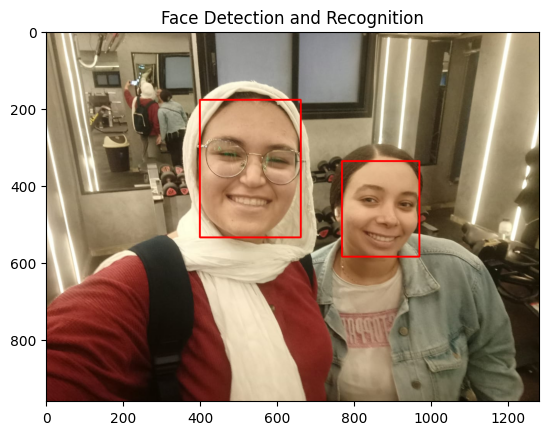

In [48]:
test_image = cv2.cvtColor(cv2.imread(r"WhatsApp Image 2024-08-24 at 14.36.25_0dd71265.jpg"), cv2.COLOR_BGR2RGB)
detected_frame, faces,startX ,startY = detect_faces(net,test_image)
for face in faces:
    identity_verified = verify(face, model, 0.5, 0.5)
    print(identity_verified[1]) 
    #verify_txt = "True" if identity_verified[1] else "False"
    # Display the recognized identity near the bounding box
    #cv2.putText(detected_frame, verify_txt, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (20,0, 255), 2)

plt.title('Face Detection and Recognition')
plt.imshow(detected_frame)

In [ ]:
# establish a connection to the webcam
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
if not cap.isOpened():
    print("Cannot open camera")
    exit()
while cap.isOpened:
    # capture the frame at that point in time
    ret, frame = cap.read()  # returns value and frame
    # image back to screen
    cv2.imshow('Image Collection', frame)
    
    # breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
# release the webcam
cap.release()
# close the image window frame
cv2.destroyAllWindows()    

In [ ]:
#detected_frame, faces,startX ,startY = detect_faces(net,frame)

for face in faces:     
    identity_verified = verify(frame, model, 0.5, 0.5)
    print(identity_verified[1]) 
    verify_txt = "Verified" if identity_verified[1] else "Not verified"
    # Display the recognized identity near the bounding box
    cv2.putText(detected_frame, verify_txt, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (20,0, 255), 2)

True


In [ ]:
detected_frame, faces,startX ,startY = detect_faces(net,frame)

for face in faces:     
    identity_verified = verify(face, model, 0.5, 0.5)
    print(identity_verified[1]) 
    verify_txt = "Verified" if identity_verified[1] else "Not verified"
    # Display the recognized identity near the bounding box
    cv2.putText(detected_frame, verify_txt, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (20,0, 255), 2)

True
